<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/350_normal_normal_model.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(distr-coniugate-2-notebook)=
# Distribuzioni coniugate (2)

In questo capitolo, esploreremo il modello normale-normale. Una caratteristica distintiva di questo modello risiede nella proprietà di auto-coniugazione della distribuzione gaussiana rispetto a una funzione di verosimiglianza anch'essa gaussiana. In altre parole, se la funzione di verosimiglianza segue una distribuzione gaussiana, scegliere una distribuzione a priori gaussiana per la media garantirà che anche la distribuzione a posteriori, a sua volta, rimanga gaussiana.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

## Derivazione della distribuzione a posteriori nel caso Normale-Normale con varianza nota

Consideriamo una situazione in cui i dati $y$ costituiscono un campione casuale estratto da una popolazione che segue la distribuzione normale. Questo implica che le singole osservazioni possono essere considerate come una sequenza di variabili casuali indipendenti e identicamente distribuite secondo la legge normale. In altre parole:

$$
Y_1, \dots, Y_n  \stackrel{iid}{\sim} \mathcal{N}(\mu, \sigma).
$$

Abbiamo già trattato in un capitolo precedente il fatto che, in queste circostanze, la verosimiglianza $p(y \mid \mu, \sigma)$ segue una distribuzione normale. Per effettuare inferenze sul parametro $\mu$, supponiamo che $\sigma$ sia noto e impostiamo una distribuzione a priori normale sulla media $\mu$. Questo costituisce il cosiddetto schema coniugato normale-normale. In questo caso, è possibile derivare analiticamente la distribuzione a posteriori $p(\mu \mid y)$, ma la trattazione matematica è complessa e qui verrà solo accennata. 

Pertanto, si pone il problema di determinare $p(\mu \mid y)$ avendo osservato un campione casuale $Y_1, \dots, Y_n \stackrel{iid}{\sim} \mathcal{N}(\mu, \sigma)$, supponendo che $\sigma$ sia perfettamente nota e assegnando a $\mu$ una distribuzione a priori normale. Ricordiamo che la densità gaussiana è espressa come:

$$
p(y_i \mid \mu, \sigma) = \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_i - \mu)^2}{2\sigma^2}}\right\}.
$$

Poiché le variabili sono indipendenti e identicamente distribuite, la densità congiunta può essere ottenuta moltiplicando le singole densità, il che conduce a:

$$
p(y \mid \mu) = \prod_{i=1}^n p(y_i \mid \mu).
$$

Definendo la densità a priori come:

$$
p(\mu) = \frac{1}{{\sigma_0 \sqrt {2\pi}}}\exp\left\{{-\frac{(\mu - \mu_0)^2}{2\sigma_0^2}}\right\},
$$

dove $\mu_0$ rappresenta il valore più probabile per $\mu$ e $\sigma_0^2$ riflette l'incertezza iniziale associata a tale valore, si può dedurre una distribuzione a posteriori gaussiana:

$$
p(\mu \mid y) = \frac{1}{{\sigma_p \sqrt {2\pi}}}\exp\left\{{-\frac{(\mu - \mu_p)^2}{2\sigma_p^2}}\right\},
$$

con:

$$
\mu_p = \frac{\frac{1}{\sigma_0^2}\mu_0+ \frac{n}{\sigma^2}\bar{y}}{\frac {1}{\sigma_0^2} + \frac{n}{\sigma^2}} 
$$

e

$$
\sigma_p^2 = \frac{1}{\frac {1}{\sigma_0^2}+ \frac{n}{\sigma^2}}.
$$

In conclusione, il risultato ottenuto sottolinea che:

- il valore atteso a posteriori è una media pesata tra il valore atteso a priori $\mu_0$ e la media campionaria $\bar{y}$, con il peso della media campionaria aumentante con il numero di osservazioni $n$ e l'incertezza iniziale $\sigma_0^2;$
- l'incertezza a posteriori $\sigma_p^2$ è sempre inferiore all'incertezza a priori $\sigma_0^2$ e diminuisce all'aumentare di $n$.

## Un esempio concreto

Per esaminare un esempio pratico, consideriamo i 30 valori BDI-II dei soggetti clinici esaminati da {cite}`zetsche_2019future`.

In [3]:
y = np.array(
    [
        26.0,
        35.0,
        30,
        25,
        44,
        30,
        33,
        43,
        22,
        43,
        24,
        19,
        39,
        31,
        25,
        28,
        35,
        30,
        26,
        31,
        41,
        36,
        26,
        35,
        33,
        28,
        27,
        34,
        27,
        22,
    ]
)

In [4]:
y_bar = np.mean(y)
print(y_bar)

30.933333333333334


La varianza $\sigma^2$ della popolazione viene ipotizzata come identica alla varianza del campione:

In [5]:
sigma = np.std(y)
sigma

6.495810615739622

Per fare un esempio, imponiamo su $\mu$ una distribuzione a priori $\mathcal{N}(30, 5)$. In tali circostanze, la distribuzione a posteriori del parametro $\mu$ può essere determinata per via analitica e corrisponde ad una Normale di media definita dall'eq. {eq}`eq-post-norm-mup` e varianza definita dall'eq. {eq}`eq-post-norm-taup2`. La figura seguente mostra un grafico della distribuzione a priori, della verosimiglianza e della distribuzione a posteriori di $\mu$.

Iniziamo con la verosimiglianza.

In [6]:
def gaussian(y, m, s):
    l = np.prod(stats.norm.pdf(y, loc=m, scale=s))
    return l

In [7]:
x_axis = np.arange(18, 38, 0.01)
s = np.std(y)
like = [gaussian(y, val, s) for val in x_axis]
l = like / np.sum(like) * 100

Usando l'eq. {eq}`eq-post-norm-mup`, definiamo una funzione che ritorna la media della distribuzione a posteriori di $\mu$.

In [8]:
def mu_post(sigma_0, mu_0, sigma, ybar, n):
    return (1 / sigma_0**2 * mu_0 + n / sigma**2 * ybar) / (
        1 / sigma_0**2 + n / sigma**2
    )

Troviamo la media a posteriori.

In [9]:
mu_0 = 30  # media della distribuzione a priori per mu
sigma_0 = 5  # sd della distribuzione a priori per mu
sigma = np.std(y)  # sd del campione (assunta essere sigma)
ybar = np.mean(y)  # media del campione
n = len(y)

mu_post(sigma_0, mu_0, sigma, ybar, n)

30.883620206009738

Definiamo una funzione che ritorna la deviazione standard della distribuzione a posteriori di $\mu$.

In [10]:
def sigma_post(sigma_0, sigma, n):
    return np.sqrt(1 / (1 / sigma_0**2 + n / sigma**2))

Troviamo la deviazione standard a posteriori.

In [11]:
sigma = np.std(y)  # sd del campione (assunta essere sigma)
n = len(y)

sigma_post(sigma_0, sigma, n)

1.1539504429303373

Possiamo ora disegnare la distribuzione a posteriori per la media della popolazione, insieme alla distribuzione a priori e alla verosimiglianza.

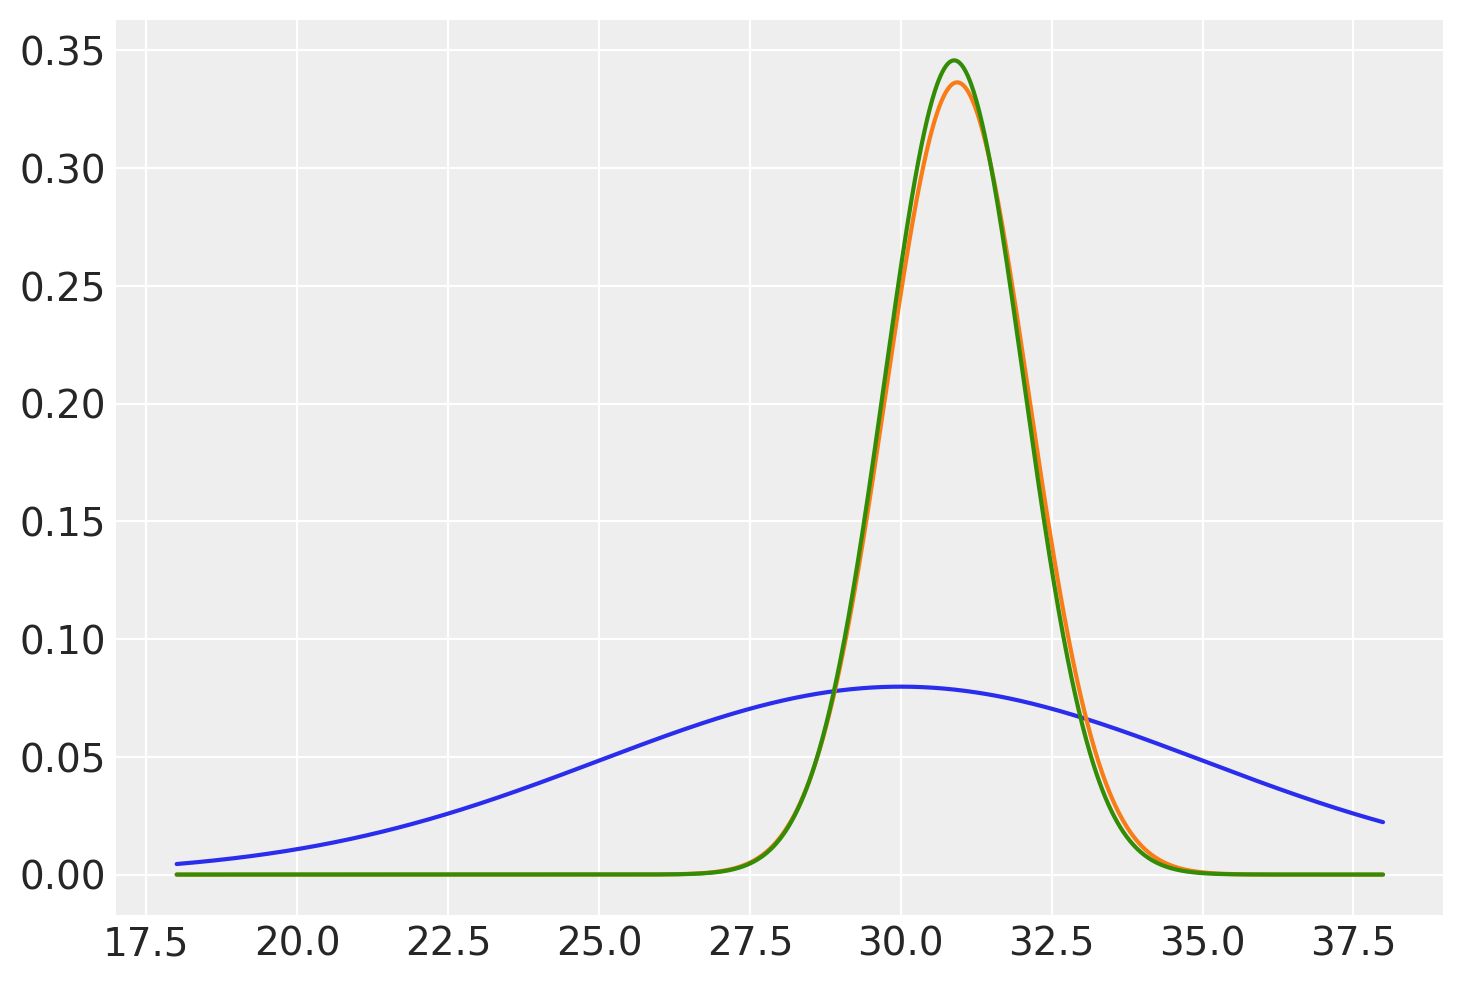

In [13]:
plt.plot(x_axis, stats.norm.pdf(x_axis, mu_0, sigma_0))
plt.plot(x_axis, l)
_ = plt.plot(
    x_axis,
    stats.norm.pdf(
        x_axis, mu_post(sigma_0, mu_0, sigma, ybar, n), sigma_post(sigma_0, sigma, n)
    ),
)

## Commenti e considerazioni finali

Nel corso di questo capitolo, abbiamo esaminato il caso del modello normale-normale all'interno del contesto dell'aggiornamento bayesiano. Questo modello presenta la seguente caratteristica: se selezioniamo una distribuzione normale come distribuzione a priori per i parametri, otteniamo una distribuzione a posteriori anch'essa normale.

Abbiamo iniziato con una distribuzione a priori definita da una media μ₀ e una varianza σ²₀. Successivamente, abbiamo considerato nuovi dati che seguono una distribuzione normale con media stimata μ̂ e varianza nota σ². Utilizzando il teorema normale-normale, abbiamo derivato le formule per la distribuzione a posteriori.

La media a posteriori μ_post è il risultato di una combinazione pesata tra la media stimata dei dati e la media a priori, influenzata dalle varianze σ²₀ e σ². La varianza a posteriori σ²_post è determinata da una formula che tiene conto delle varianze a priori e dei nuovi dati.

In sostanza, il capitolo ha fornito una panoramica di come l'aggiornamento bayesiano nel caso normale-normale semplifichi notevolmente i calcoli delle distribuzioni a posteriori, grazie alla scelta della distribuzione a priori normale. 

## Watermark

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Aug 07 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

seaborn   : 0.12.2
pandas    : 2.0.3
scipy     : 1.11.1
arviz     : 0.16.1
numpy     : 1.25.2
matplotlib: 3.7.1

Watermark: 2.4.3

